In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sqlite3
import numpy as np
import pandas as pd
from src.tables import MapTable, df_to_tmp_table, df_to_table, get_machines, get_offers, AVG_COLS, get_tables, get_tbl_info, table_to_df, get_tbl_timespan
from src.preprocess import preprocess
from src.utils import  time_utc_now, np_min_chunk, df_na_vals, reduce_mem_usage
import seaborn as sns
import matplotlib.pyplot as plt
import logging

import warnings

# Filter out all warnings related to pandas
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
conn = sqlite3.connect('../vast.db')
df = table_to_df('pcie_bw_snp', conn)
conn.close()

In [18]:
df.index.name

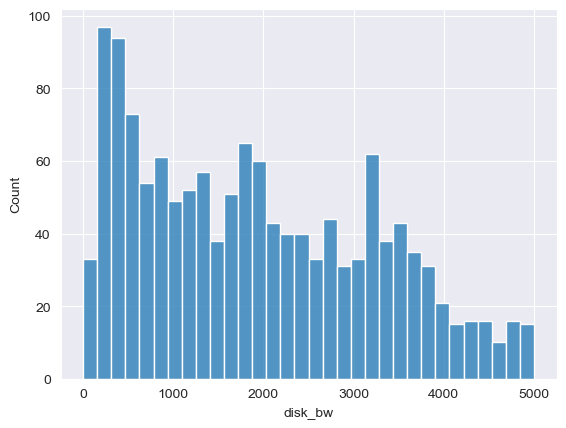

In [5]:
sns.histplot(df.query('disk_bw < 5000').disk_bw, bins=32);
# sns.histplot(df.disk_bw, bins=32);

In [38]:
conn = sqlite3.connect('../vast.db')
disk_bw = table_to_df('disk_bw_ts', conn)
conn.close()

In [34]:
disk_bw = pd.read_sql('''WITH t AS (
    SELECT *, COUNT() FROM disk_bw_ts
    GROUP BY machine_id, disk_bw
    HAVING COUNT() > 1
)
SELECT disk_bw_ts.*
FROM disk_bw_ts
INNER JOIN t ON disk_bw_ts.machine_id = t.machine_id''', conn)
disk_bw

,machine_id,disk_bw,timestamp
0,162,2000,1694581313
1,162,2000,1694581313
2,1831,5000,1694581313
3,2107,6000,1694581313
4,2107,6000,1694581313
...,...,...,...
2777,12964,800,1694582772
2778,12974,1000,1694582772
2779,12981,2000,1694582772
2780,12985,2500,1694582772


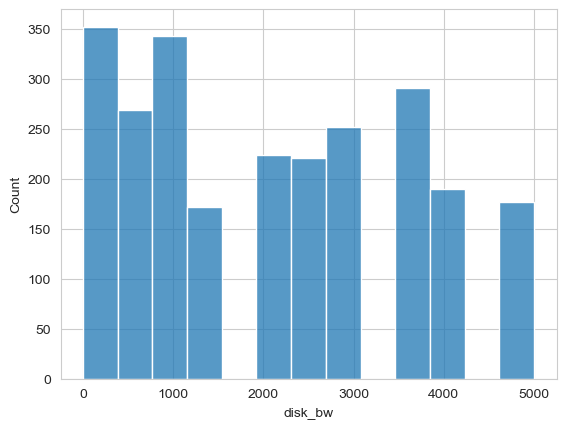

In [37]:
sns.histplot(disk_bw.query('disk_bw < 6000').disk_bw);

In [3]:
from src.utils import round_base

df = get_machines()

In [15]:
df.columns

Index(['bw_nvlink', 'chunks', 'client_run_time', 'compute_cap', 'cpu_cores',
       'cpu_name', 'cpu_ram', 'credit_balance', 'credit_discount',
       'credit_discount_max', 'cuda_max_good', 'direct_port_count',
       'discount_rate', 'discounted_dph_total', 'discounted_hourly', 'disk_bw',
       'disk_name', 'disk_space', 'dlperf', 'dlperf_per_dphtotal', 'dph_base',
       'driver_version', 'duration', 'end_date', 'flops_per_dphtotal',
       'geolocation', 'gpu_display_active', 'gpu_lanes', 'gpu_mem_bw',
       'gpu_name', 'gpu_ram', 'gpu_totalram', 'has_avx', 'host_id',
       'host_run_time', 'hosting_type', 'inet_down', 'inet_down_cost',
       'inet_up', 'inet_up_cost', 'location', 'machine_id', 'min_bid',
       'min_chunk', 'mobo_name', 'num_gpus', 'num_gpus_rented', 'pci_gen',
       'pcie_bw', 'public_ipaddr', 'reliability2', 'score', 'start_date',
       'static_ip', 'storage_cost', 'total_flops', 'verification', 'verified',
       'vram_costperhour', 'timestamp'],
      dt

In [8]:
df.host_run_time.value_counts()

2592000    1491
Name: host_run_time, dtype: int64

In [86]:
round_base(df.pcie_bw * 10, base=5)

0       125
1       125
2        65
3       110
4        15
       ... 
1477     55
1478     60
1479     55
1480     55
1481    125
Name: pcie_bw, Length: 1482, dtype: int32

In [26]:
conn = sqlite3.connect('../data/vast_old.db')
print(get_tbl_timespan('reliability_ts', conn))
conn.close()

29 days 03:31:42


In [209]:
import sqlite3
import os
import pandas as pd

db_path = '../data/vast.db'

conn = sqlite3.connect(db_path)
timespan = get_tbl_timespan('timestamp_tbl', conn)
total_days = timespan.total_seconds() / (3600 * 24)

print('Timespan:', timespan)

conn.execute('VACUUM')
size = os.path.getsize(db_path) / (1024 * 1024) # Size in Mb

print(f'Size per day: {size / total_days: .2f} mb')
print(f'Size per year: {size / total_days * 365: .0f} mb')

conn.close()

Timespan: 1 days 23:49:05
Size per day:  8.29 mb
Size per year:  3027 mb


In [211]:
conn = sqlite3.connect(db_path)
df_snp = table_to_df('disk_bw_ts', conn)
conn.close()

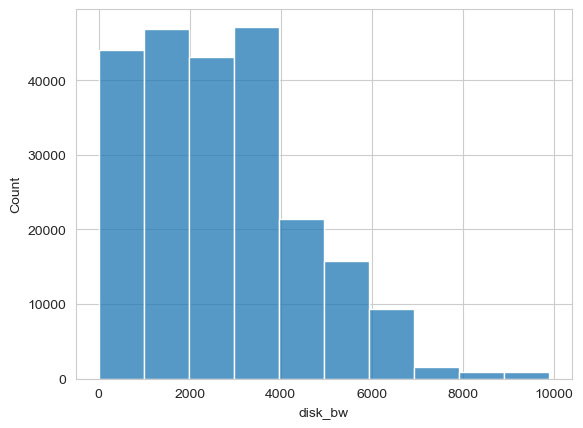

In [220]:
sns.histplot(df_snp.query('disk_bw < 10000').disk_bw, bins=10);
# sns.histplot(df_snp.disk_bw, bins=10);

In [129]:
from src.utils import reduce_mem_usage

conn = sqlite3.connect(db_path)
df = table_to_df('gpu_mem_bw_snp', conn)
conn.close()

df = reduce_mem_usage(df)

In [157]:
df_tmp = df.query('machine_id == 4383')
df_tmp

name,machine_id,gpu_mem_bw,timestamp
75,4383,600,1694621024
30609,4383,650,1694629102
225223,4383,650,1694678229
269240,4383,600,1694689361
269494,4383,600,1694689463
489663,4383,650,1694746621
490294,4383,600,1694746726
490589,4383,650,1694746778


In [97]:
df_tmp.gpu_mem_bw.round(-1)

2         210
10747     210
161461    220
191987    210
368358    220
479677    190
Name: gpu_mem_bw, dtype: int16

array([], dtype=int64)

In [158]:
slice_idx_ = np.diff(df_tmp.gpu_mem_bw).nonzero()[0] + 1
slice_idx_ = np.hstack([0, slice_idx_])
slice_idx = df_tmp.index[slice_idx_]
mask = df.index.isin(slice_idx)

In [163]:
df[mask]

name,machine_id,gpu_mem_bw,timestamp
75,4383,600,1694621024
30609,4383,650,1694629102
269240,4383,600,1694689361
489663,4383,650,1694746621
490294,4383,600,1694746726
490589,4383,650,1694746778


In [160]:
slice_idx

Int64Index([75, 30609, 269240, 489663, 490294, 490589], dtype='int64')

In [225]:
conn.close()

In [6]:
""" Round columns in database """

from tqdm import tqdm
import sqlite3
import numpy as np
from src.tables import table_to_df
from src.utils import reduce_mem_usage, custom_round, round_base

col = 'disk_bw'
table_name = col + '_ts'

conn = sqlite3.connect('../data/vast.db')
df = table_to_df(table_name, conn)
# conn.close()
df = reduce_mem_usage(df)


# df[col] = round_base(df[col], base=50)
df[col] = custom_round(df[col], [(1000, 100), (2000, 200), (4000, 500), (100000, 1000)])
# df[col] = df[col].round(-2)

mask = np.zeros(df.shape[0], dtype=bool)

for m_id in tqdm(df.machine_id.unique()):
    df_tmp = df.query('machine_id == @m_id')
    abs_idx = np.diff(df_tmp[col]).nonzero()[0] + 1
    abs_idx = np.hstack([0, abs_idx])
    slice_idx = df_tmp.index[abs_idx]
    mask |= df.index.isin(slice_idx)
    # print('machine_id', m_id, mask.sum())
    # print(slice_idx.values)

print(mask.sum())

df[mask].to_sql(table_name+'_rnd', conn, index=False, if_exists='replace')

conn.commit()
conn.close()

100%|██████████| 1576/1576 [00:11<00:00, 132.94it/s]


169192


In [29]:
""" Average columns in database """

from tqdm import tqdm
import sqlite3
import pandas as pd
import numpy as np
from src.tables import table_to_df
from src.utils import reduce_mem_usage, custom_round, round_base

col = 'disk_bw'
table_name = col + '_ts'

conn = sqlite3.connect('../data/vast.db')
df = table_to_df(table_name, conn)
# conn.close()
df = reduce_mem_usage(df)

df.index = pd.to_datetime(df.timestamp, unit='s')

In [40]:
df.groupby('machine_id')['disk_bw'].resample('1D').mean().round().astype(np.uint16).reset_index().to_sql('disk_bw_avg', conn, if_exists='replace', index=False)

4553

In [41]:
df.groupby('machine_id')['disk_bw'].resample('1D').std().fillna(0).astype(np.uint16).reset_index().to_sql('disk_bw_std', conn, if_exists='replace', index=False)

4553

In [36]:
df.query('machine_id == 2106')

name,machine_id,disk_bw,timestamp
timestamp,,,
2023-09-14 01:48:07,2106,2152,1694656087


In [31]:
df.groupby('machine_id')['disk_bw'].mean().round().astype(np.uint16)

AttributeError: 'Series' object has no attribute 'timestamp'

In [224]:
conn.close()

In [57]:
import os
import pandas as pd
import numpy as np
import sqlite3

db_path = '../data/test.db'

int32_arr = np.random.randint(0, np.iinfo(np.uint32).max, size=1000000, dtype=np.uint32)
df_int32 = pd.DataFrame(int32_arr)
ts_arr = pd.to_datetime(int32_arr, unit='s')
df_ts = pd.DataFrame(ts_arr)

conn = sqlite3.connect(db_path)
df_int32.to_sql('int32', conn, index=False, if_exists='replace')
df_ts.to_sql('ts', conn, index=False, if_exists='replace')
conn.execute('VACUUM')
conn.close()

os.path.getsize(db_path) // (1024 * 1024)

40255488

In [8]:
import os
os.getcwd()

'C:\\Users\\ergot\\DataspellProjects\\vast-stats\\notebooks'

In [9]:
import requests 
r = requests.get('https://500.farm/vastai-exporter/machines', timeout=5)

# ts = int(pd.to_datetime(r.json()['timestamp']).timestamp())
# raw = pd.DataFrame(r.json()["offers"])
# raw['timestamp'] = ts

In [10]:
len(r.text)

4457419

In [11]:
%%time
len(r.text)

CPU times: total: 0 ns
Wall time: 3 ms


4457419

In [12]:
df = get_offers()

In [13]:
from src.tables import _get_raw, offers_url
from src.utils import np_group_by

raw = _get_raw(offers_url)

cols = ['machine_id', 'id', 'num_gpus']
# 
raw[cols]
# df[cols].sort_values(by=['machine_id', 'num_gpus'])

,machine_id,id,num_gpus
0,11446,6876831,14
1,12109,6931083,14
2,12195,6891180,14
3,12129,6857985,14
4,12171,6804463,14
...,...,...,...
6005,12902,6970220,1
6006,10903,6778940,1
6007,10903,6778938,1
6008,9528,6751513,1


In [14]:
arr = np.array([raw.machine_id, raw.num_gpus]).T
arr[:10]

array([[11446,    14],
       [12109,    14],
       [12195,    14],
       [12129,    14],
       [12171,    14],
       [10298,    14],
       [11795,    14],
       [10163,    14],
       [12803,    12],
       [12639,    12]], dtype=int64)

In [15]:
# arr = np.array([
#                 [274, 1], 
#                 [274, 2],
#                 [274, 1],
#                 [5601, 1],
#                 [5601, 2],
#                 [8506, 4],
#                 [8506, 2],
#                 ],)
# arr

In [16]:
arr[:, 0]

array([11446, 12109, 12195, ..., 10903,  9528, 12598], dtype=int64)

In [17]:
ids = arr[:, 0]
vals = arr[:, 1]

sort_idx = np.argsort(ids)
ids = ids[sort_idx]
vals = vals[sort_idx]

slice_idx = np.diff(ids).nonzero()[0] + 1
slice_idx = np.hstack([0, slice_idx])

In [18]:
np.all(np.r_[0, slice_idx] == np.insert(slice_idx, 0, 0)), \
np.all(np.hstack([0, slice_idx]) == np.insert(slice_idx, 0, 0))

(True, True)

In [19]:
np.hstack([0, slice_idx])

array([   0,    0,    1, ..., 6005, 6008, 6009], dtype=int64)

In [20]:
%timeit np.r_[0, slice_idx]
%timeit np.insert(slice_idx, 0, 0)
%timeit np.hstack([0, slice_idx])

10.9 µs ± 413 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
15.2 µs ± 20.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
5.89 µs ± 42.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [21]:
%timeit np.diff(ids).nonzero()[0]
%timeit np.flatnonzero(np.diff(ids))

32.1 µs ± 158 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
35.2 µs ± 149 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [22]:
n = vals.max() + 1
n

15

In [23]:
idx_arr = np.zeros(vals.size,dtype=int)
idx_arr[slice_idx] = 1
idx_arr

array([1, 1, 0, ..., 0, 1, 1])

In [24]:
offset = n * idx_arr.cumsum()
offset

array([   15,    30,    30, ..., 22230, 22245, 22260])

In [25]:
argidx = np.argsort(vals + offset)
argidx

array([   0,   12,    7, ..., 6007, 6008, 6009], dtype=int64)

In [26]:
vals[argidx]

array([4, 1, 1, ..., 2, 1, 1], dtype=int64)

In [27]:
last_grp_idx = np.append(slice_idx[1:], vals.size) - 1
last_grp_idx

array([   0,   15,   30, ..., 6007, 6008, 6009], dtype=int64)

In [28]:
max_grp = vals[argidx[last_grp_idx]]
max_grp

array([4, 8, 8, ..., 2, 1, 1], dtype=int64)

In [29]:
from src.utils import np_argmax_reduceat

arr = np.array([
    [8506, 4],
    [274,  2],
    [8506, 2],
    [274,  1],    
],)

ids = arr[:, 0]
vals = arr[:, 1]

sort_idx = np.argsort(ids)
ids = ids[sort_idx]
vals = vals[sort_idx]

slice_idx = np.diff(ids).nonzero()[0] + 1
slice_idx = np.hstack([0, slice_idx])

vals[np_argmax_reduceat(vals, slice_idx)]

array([2, 4])

In [30]:
ids[slice_idx]

array([ 274, 8506])

In [31]:
_raw = _get_raw(offers_url)

In [32]:
def test_lexsort(raw):    
    lexidx = np.lexsort((raw.num_gpus.values, raw.machine_id.values))
    return raw.iloc[lexidx]

def test_pd_sort(raw):
    return raw.sort_values(by=['machine_id', 'num_gpus'])

In [33]:
%timeit test_lexsort(raw)
%timeit test_pd_sort(raw)

2.32 ms ± 279 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.32 ms ± 80.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [64]:
_raw = _get_raw(offers_url)

In [71]:
raw = _raw.copy()

In [78]:
%%time
def _get_slices(raw: pd.DataFrame):
    # raw.sort_values(by=['machine_id', 'num_gpus'], inplace=True)
    # lexidx = np.lexsort((raw.num_gpus.values, raw.machine_id.values))
    # raw = raw.iloc[lexidx]

    machine_ids, num_gpus = raw.machine_id.values, raw.num_gpus.values

    slice_idx = np.diff(machine_ids).nonzero()[0] + 1
    slice_idx = np.hstack([0, slice_idx])    # insert zero at the beginning of slice_idx

    group_count = np.diff(np.concatenate([slice_idx, [machine_ids.size]]))  # groupby('machine_id').count()
    return slice_idx, group_count    


def _gpu_min_chunk(raw, slice_idx, group_count):
    machine_ids, num_gpus = raw.machine_id.values, raw.num_gpus.values
    
    min_chunk_machines = num_gpus[slice_idx]
    min_chunk = np.repeat(min_chunk_machines, group_count)    # expanded min_chunk for each offer
    min_chunk_count = np.add.reduceat((min_chunk == num_gpus), slice_idx)
    
    # correction for the case where whole machine size is not a multiple of min_chunk
    # in this case, there is always a single remainder chunk which is smaller than actual min_chunk
    # examples: [1 2 2 2 3 4 7], actual min_chunk is 2
    #           [3 4 7], actual min_chunk is 4
    
    idx = (min_chunk_count == 1) & (group_count >= 3)
    
    # get second minimum, correct for last index
    second_min_idx = slice_idx + 1
    if second_min_idx[-1] == machine_ids.size:
        second_min_idx[-1] -= 1
    
    min_chunk_machines[idx] = num_gpus[second_min_idx][idx]
    
    # update min_chunk
    min_chunk = np.repeat(min_chunk_machines, group_count)
    return min_chunk


def _get_offers(raw, min_chunk):
    # filter offers only 
    return raw[raw.num_gpus <= min_chunk].copy()

def _get_machines(raw, slice_idx):
    # machines = only offers with max gpu
    machine_ids = raw.machine_id.values
    max_chunk_idx = np.append(slice_idx[1:], machine_ids.size) - 1
    machines = raw.iloc[max_chunk_idx].copy()
    return machines

def split_raw(raw: pd.DataFrame):
    raw.sort_values(by=['machine_id', 'num_gpus'], inplace=True)        
    
    slice_idx, group_count = _get_slices(raw)
    min_chunk = _gpu_min_chunk(raw, slice_idx, group_count)
    
    offers = _get_offers(raw, min_chunk)
    machines = _get_machines(raw, slice_idx)
    return machines, offers


preprocess(raw)
machines, offers = split_raw(raw)

CPU times: total: 62.5 ms
Wall time: 63 ms


[autoreload of src.tables failed: Traceback (most recent call last):
  File "C:\Users\ergot\mambaforge\envs\ml\lib\site-packages\IPython\extensions\autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\ergot\mambaforge\envs\ml\lib\site-packages\IPython\extensions\autoreload.py", line 471, in superreload
    module = reload(module)
  File "C:\Users\ergot\mambaforge\envs\ml\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "C:\Users\ergot\DataspellProjects\vast-stats\src\tables.py", line 8, in <module>
    from src.preprocess import split_raw, preprocess
ImportError: cannot import name 'split_raw' from 'src.preprocess' (C:\Users\ergot\DataspellProjects\vast-stats\src\preprocess.py)
]


In [79]:
machines

,bw_nvlink,client_run_time,compute_cap,cpu_cores,cpu_name,cpu_ram,credit_discount_max,cuda_max_good,direct_port_count,disk_bw,...,reliability,rented,score,static_ip,storage_cost,total_flops,verification,vram_costperhour,timestamp,country
2887,0,1.1,750,32,AMD Ryzen Threadripper 1950X 16-Core Processor,63,400,11.7,1000,1862,...,9975,0,4644,1,150,61,1,0.000013,1694409656,US
3348,0,1.1,610,32,Xeon® E5-2650 v2,63,100,12.0,1000,1589,...,9942,0,5615,1,150,49,1,0.000007,1694409656,UA
3349,0,1.1,610,32,Xeon® E5-2650 v2,63,100,12.0,1000,1653,...,9961,0,5028,1,150,49,2,0.000007,1694409656,UA
3516,0,1.1,610,40,Xeon® E5-2658 v2,63,100,12.0,1000,487,...,9889,0,5149,1,150,37,1,0.000007,1694409656,UA
1470,0,1.1,610,32,Xeon® E5-2650 v2,126,100,12.0,1000,2882,...,9896,0,4698,1,150,92,2,0.000008,1694409656,UA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4961,0,1.1,860,12,AMD Ryzen 5 3600 6-Core Processor,16,400,12.0,101,3280,...,6000,0,1076,1,150,29,0,0.000012,1694409656,US
5335,0,1.1,860,28,Xeon® E5-2690 0,85,400,12.2,999,1801,...,6000,0,752,1,101,25,0,0.000007,1694409656,CA
3940,0,1.1,860,16,AMD Ryzen 9 5950X 16-Core Processor,31,250,12.2,20,519,...,5727,0,1952,1,150,35,0,0.000004,1694409656,US
4960,0,1.1,860,16,AMD Ryzen 7 5800X 8-Core Processor,16,400,12.2,100,542,...,6000,0,1333,1,150,29,0,0.000010,1694409656,US


In [38]:
from src.tables import machines_url

vast_exported = _get_raw(machines_url).machine_id

In [39]:
machines[~machines.machine_id.isin(vast_exported)].machine_id

1309    5919
1310    6312
Name: machine_id, dtype: int32

In [40]:
offers.columns

Index(['bw_nvlink', 'client_run_time', 'compute_cap', 'cpu_cores', 'cpu_name',
       'cpu_ram', 'credit_discount_max', 'cuda_max_good', 'direct_port_count',
       'disk_bw', 'disk_name', 'disk_space', 'dlperf', 'dph_base',
       'driver_version', 'end_date', 'gpu_display_active', 'gpu_lanes',
       'gpu_mem_bw', 'gpu_name', 'gpu_ram', 'gpu_totalram', 'has_avx',
       'host_id', 'hosting_type', 'id', 'inet_down', 'inet_down_cost',
       'inet_up', 'inet_up_cost', 'machine_id', 'min_bid', 'mobo_name',
       'num_gpus', 'pci_gen', 'pcie_bw', 'public_ipaddr', 'reliability',
       'rented', 'score', 'static_ip', 'storage_cost', 'total_flops',
       'verification', 'vram_costperhour', 'timestamp', 'country'],
      dtype='object')

In [41]:
raw.query('machine_id == 6312')[['id', 'num_gpus', 'rented']]

,id,num_gpus,rented
1306,5516886,4,1
1310,5381482,4,1
3102,5516889,2,1
3103,5516887,2,1
3110,5381485,2,1
3111,5381483,2,1
4923,5516888,1,1
4924,5516885,1,1
4925,5516884,1,1
4926,5516883,1,1


In [42]:
offers.query('machine_id == 6312')[['id', 'num_gpus', 'rented']]

,id,num_gpus,rented
4923,5516888,1,1
4924,5516885,1,1
4925,5516884,1,1
4926,5516883,1,1
4940,5381484,1,1
4941,5381481,1,1
4942,5381480,1,1
4943,5381479,1,1


In [43]:
machines.query('machine_id == 6312')[['num_gpus']]

,num_gpus
1310,4


In [44]:
raw[['machine_id', 'num_gpus']]

,machine_id,num_gpus
0,11446,14
1,12109,14
2,12195,14
3,12129,14
4,12171,14
...,...,...
6005,12902,1
6006,10903,1
6007,10903,1
6008,9528,1


In [45]:
import sqlite3

# Connect to the database
conn = sqlite3.connect('../vast.db')
cursor = conn.cursor()

# Get list of table names
tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()

# Iterate through tables and check for NULL values
for table in tables:
    table_name = table[0]

    # Get list of column names in the table
    columns = cursor.execute(f"PRAGMA table_info({table_name})").fetchall()

    for column in columns:
        column_name = column[1]
        query = f"SELECT * FROM {table_name} WHERE {column_name} IS NULL"
        null_rows = cursor.execute(query).fetchall()
        if len(null_rows) > 0:
            print(f"Table '{table_name}', Column '{column_name}' has NULL values.")

# Close the connection
conn.close()

In [46]:
df = pd.DataFrame()

In [47]:
import sqlite3
import os
import numpy as np

DB_PATH = '../data'

# Create directories for databases if they don't exist
if not os.path.exists(DB_PATH):
    os.makedirs(DB_PATH)

# Function to create and populate a database with the specified data type and range
def create_and_populate_db(db_name, data_type, value_range, size=10000):
    db_path = os.path.join(DB_PATH, db_name)

    conn = sqlite3.connect(db_path)

    conn.execute(f"CREATE TABLE data (value {data_type})")


    # Generate and insert values within the specified range
    values = None
    if 'INTEGER' in data_type:
        values = np.random.randint(*value_range, size=size)
    elif 'REAL' in data_type:
        values = np.random.uniform(*value_range, size=size)
    else:
        raise ValueError('Unknown type')        
        
    rows = [(value,) for value in values]
    
    
    try:
        # print(rows[:3])
        # conn.executemany("INSERT INTO data (value) VALUES (?)", rows)

        for value in values:
            conn.execute(f"INSERT INTO data (value) VALUES ({value})")

        conn.commit()  
        conn.execute("VACUUM")    
    
    except Exception as e:
        print(e)
    
    conn.close()

# delete exiting db's
for db_name in [f for f in os.listdir(DB_PATH) if f.endswith('.sqlite')]:
    db_path = os.path.join(DB_PATH, db_name)
    os.remove(db_path)


# Create and populate the databases
create_and_populate_db('integer_db.sqlite', 'INTEGER', (0, 1000))  
create_and_populate_db('integer_non_null_db.sqlite', 'INTEGER NOT NULL', (0, 1000))
create_and_populate_db('real_db.sqlite', 'REAL', (0, 1000))            
create_and_populate_db('real_non_null_db.sqlite', 'REAL NOT NULL', (0, 1000))            
# Print database sizes
for db_name in [f for f in os.listdir(DB_PATH) if f.endswith('.sqlite')]:
    db_path = os.path.join(DB_PATH, db_name)
    db_size = os.path.getsize(db_path) / (1024)  # Size in KB
    print(f"Database '{db_name}' size: {db_size:.2f} KB")

Database 'integer_db.sqlite' size: 96.00 KB
Database 'integer_non_null_db.sqlite' size: 96.00 KB
Database 'real_db.sqlite' size: 156.00 KB
Database 'real_non_null_db.sqlite' size: 156.00 KB


In [48]:
import os
import psutil

In [49]:
# Getting loadover15 minutes
load1, load5, load15 = psutil.getloadavg()

cpu_usage = (load15/os.cpu_count()) * 100

print("The CPU usage is : ", load1)

The CPU usage is :  0.0


In [50]:
import platform
platform.processor()

'AMD64 Family 23 Model 113 Stepping 0, AuthenticAMD'

In [51]:
psutil.cpu_freq()

scpufreq(current=3593.0, min=0.0, max=3593.0)

In [52]:
psutil.cpu_percent(interval=1)

12.2

In [53]:
os.cpu_count()

24

In [54]:
conn.execute('CREATE TABLE tmp (id, mid)')

ProgrammingError: Cannot operate on a closed database.

In [ ]:
conn.execute('INSERT INTO tmp VALUES (1, 2)').fetchall()
# conn.close()

In [ ]:
conn.execute('DROP TABLE IF EXISTS map_tbl').fetchall()

In [ ]:
conn.commit()
get_tables(conn)

In [ ]:
conn.close()

In [ ]:
conn.execute('DROP TABLE IF EXISTS map_tbl')
map_tbl = MapTable(
    'map_tbl',
    'tmp',
    ['id', 'mid']
)
map_tbl.init_db(conn)
assert 'map_tbl' in get_tables(conn)
info = get_tbl_info('map_tbl', conn)
assert info.loc[info.name == 'id', 'pk'].all()
assert (info.name == 'mid').any()

In [ ]:
(info.name == 'mid').any()

In [ ]:
all(info.loc[info.name == 'id', 'pk'])

In [ ]:
get_tables(conn)

In [ ]:
table_to_df('reliability_ts', conn)

In [ ]:
conn.close()

In [ ]:
machines = get_machines()
preprocess(machines)
df_to_tmp_table(machines, 'tmp_machines', conn)

In [ ]:
machines.info()

In [ ]:
table.init_db(conn)

In [ ]:
conn = sqlite3.connect('../data/vast.db')

In [ ]:
df = table_to_df('rent_ts', conn)

In [ ]:
df['date'] = (df.timestamp * 1e9).apply(pd.to_datetime)

In [ ]:
df[df.machine_id == 8506]

In [ ]:

sns.lineplot(df.query('machine_id == 8506'), x='date', y='rented');
plt.xticks(rotation=90);